<a href="https://colab.research.google.com/github/marzione00/7a34747f/blob/master/Copia_di_Copia_di_Fruit_recognition%2BBoltzmann%2BCONV_30032021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the Libraries

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras import layers
import pathlib
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
from sklearn.neural_network import BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline

The pictures are downloaded from 3 dropobox folders: the TRAINING folder includes the training set and the validation set while the TEST folder contains the final test set. Finally the multiple fruit set includes pictures where the fruits are merged into different contexts in order to check the NN robustness. Furthermore, for each set, the respective number of items is checked. Solution adpated from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [2]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


data_dir = tf.keras.utils.get_file(origin="https://www.dropbox.com/s/9pm18i62bxfwswp/TRAINING.tar?dl=1", 
                                   fname='TRAINING', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

data_Y = tf.keras.utils.get_file(origin="https://www.dropbox.com/s/q8lg83of5kzozol/TEST.tar?dl=1", 
                                   fname='TEST', 
                                   untar=True)

data_Y = pathlib.Path(data_Y)
image_count_testY = len(list(data_Y.glob('*/*.jpg')))
print(image_count_testY)




data_X = tf.keras.utils.get_file(origin="https://www.dropbox.com/s/w92vbi3ysfg0tk4/test-multiple_fruitsX.tar?dl=1", 
                                   fname='test-multiple_fruits', 
                                   untar=True)

data_X = pathlib.Path(data_X)
image_count_testX = len(list(data_X.glob('*/*.jpg')))
print(image_count_testX)


159039488/159031808 [==============================] - 1s 0us/step
30747
53428224/53423104 [==============================] - 0s 0us/step
10454
377675776/377673728 [==============================] - 3s 0us/step
103


A sample for each class of fruit that will be distingished by the NN 



In [3]:
batch_size = 32
img_height = 32
img_width = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30747 files belonging to 10 classes.
Using 24598 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30747 files belonging to 10 classes.
Using 6149 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_Y,
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10454 files belonging to 10 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'Banana', 'Cherry', 'Grape', 'Peach', 'Pear', 'Pepper', 'Plum', 'Potato', 'Tomato']


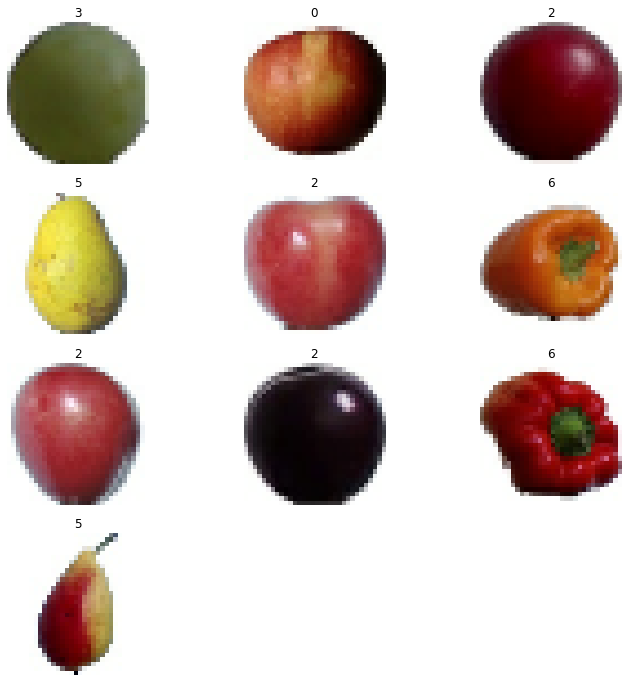

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

Creating two subgroups (items and labels) for the training, validation and test sets. Solution adapded from [Ref_kaggle](https://www.kaggle.com/calebeverett/combining-dataset-examples)

In [7]:
res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

resz = list(zip(*test_ds.unbatch().as_numpy_iterator()))
x_test = np.array(resz[0])

y_test = np.array(resz[1])

print(x_test.shape,y_test.shape)


(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
(10454, 32, 32, 3) (10454, 10)


Definition of Zero-One loss function 

In [8]:
def zero_one_loss(prediction,test):     #predictions, y_test
  y_pred = []
  y_test = []
  loss= []

  for i in range(len(test)):
    y_pred.append(np.argmax(prediction[i]))
    y_test.append(np.argmax(test[i]))
  
  for i in range(len(test)):
    if (y_pred[i] != y_test[i]):
      loss.append(1)
    else:
      loss.append(0)
  
  return np.mean(loss)

Performing the PCA on the training a validation set. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

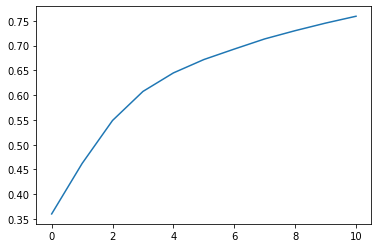

In [ ]:
X_train_for_pca = x_train.reshape(x_train.shape[0],3*32*32)
pca=PCA(n_components=0.75)
X_train_pca_out_reduced=pca.fit_transform(X_train_for_pca)
X_train_pca_out_recovered=pca.inverse_transform(X_train_pca_out_reduced)
cumsum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

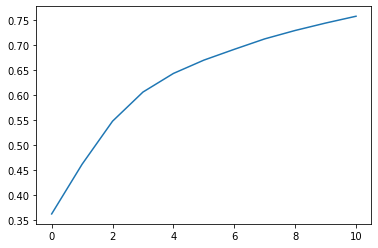

In [ ]:
X_val_for_pca = x_val.reshape(x_val.shape[0],3*32*32)
pca=PCA(n_components=0.75)
X_val_pca_out_reduced=pca.fit_transform(X_val_for_pca)
X_val_pca_out_recovered=pca.inverse_transform(X_val_pca_out_reduced)
cumsum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

In [ ]:
X_train_pca_out_recovered=X_train_pca_out_recovered.reshape(X_train_pca_out_recovered.shape[0],32,32,3)
print(X_train_pca_out_recovered.shape)
X_val_pca_out_recovered=X_val_pca_out_recovered.reshape(X_val_pca_out_recovered.shape[0],32,32,3)
print(X_val_pca_out_recovered.shape)

(24598, 32, 32, 3)
(6149, 32, 32, 3)


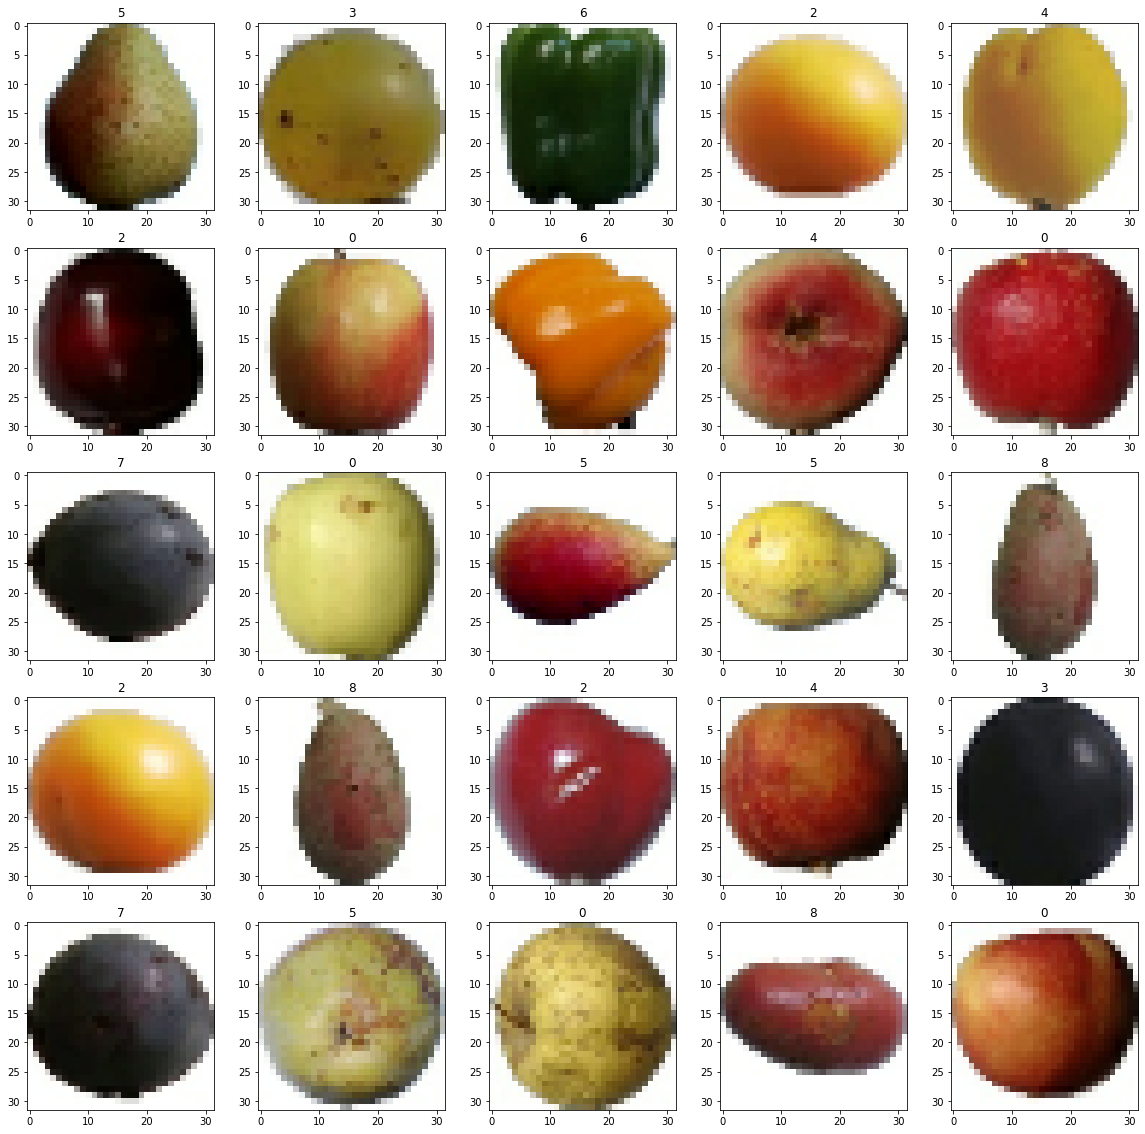

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i]))

Pictures after the PCA transform

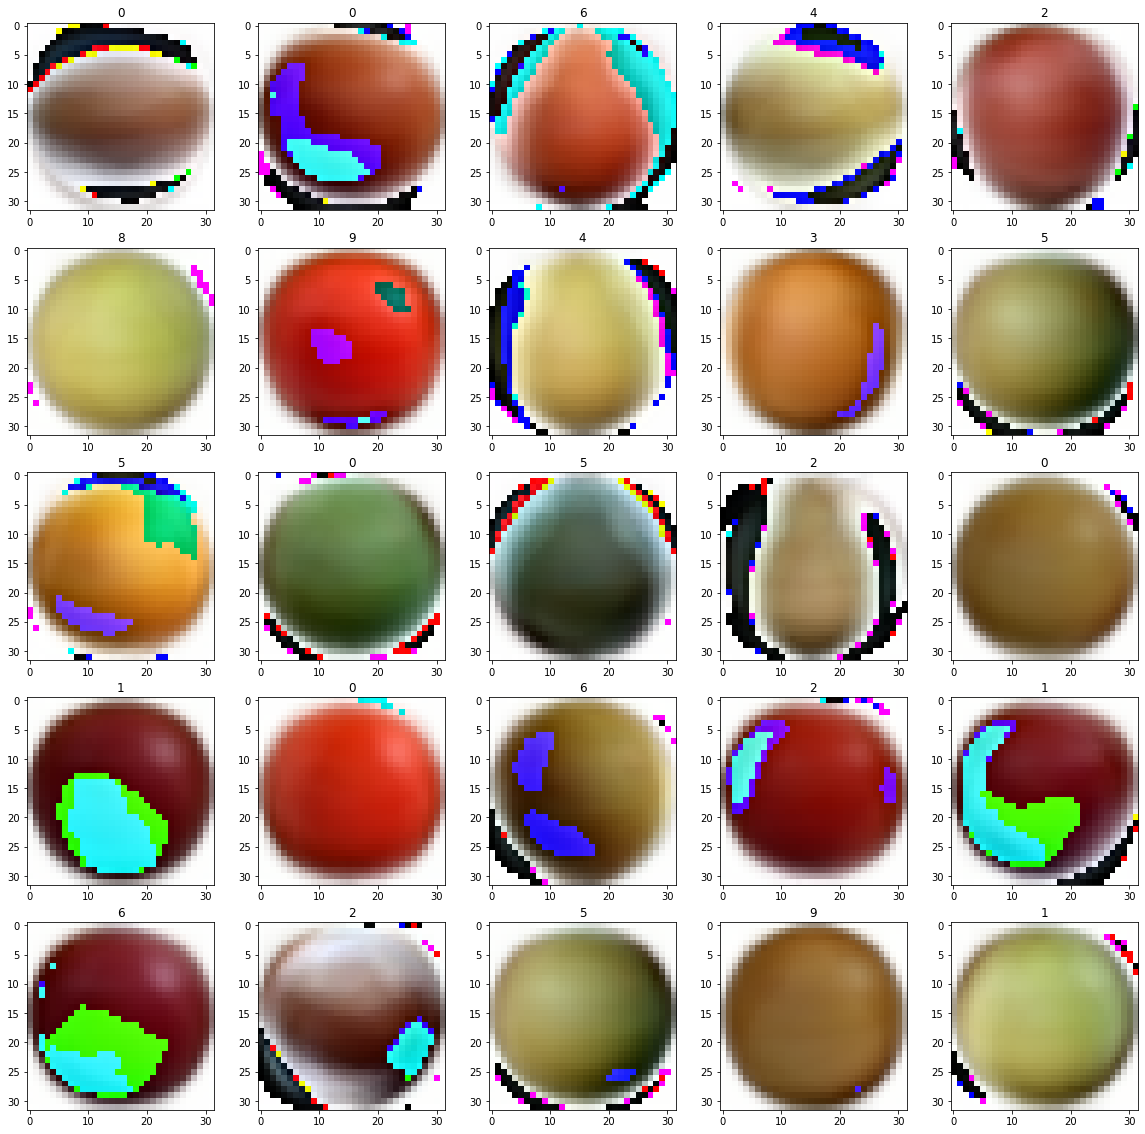

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_pca_out_recovered[i,:].astype("uint8").reshape(32,32,3))
    plt.title(np.argmax(labels[i]))

Optimization of the parameters of the rectangualar neural network. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.02)))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [1,2,3,4],
    "n_neurons": [10,15,20,25,30],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=5,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model



#print(rnd_search_cv.best_params_)
#print(rnd_search_cv.best_score_)
#model=rnd_search_cv.best_estimator_.model
#model.save("peppo.h5")

KeyboardInterrupt: ignored

Training the net with the final result. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.02)))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [1,2,3,4],
    "n_neurons": [10,15,20],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=5,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model



#print(rnd_search_cv.best_params_)
#print(rnd_search_cv.best_score_)
#model=rnd_search_cv.best_estimator_.model
#model.save("peppo.h5")

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


615/615 [==============================] - 4s 4ms/step - loss: 2.8004 - accuracy: 0.1819 - val_loss: 2.3563 - val_accuracy: 0.1888
Epoch 2/10
615/615 [==============================] - 2s 3ms/step - loss: 2.3224 - accuracy: 0.1894 - val_loss: 2.2398 - val_accuracy: 0.1888
Epoch 3/10
615/615 [==============================] - 2s 3ms/step - loss: 2.2270 - accuracy: 0.1947 - val_loss: 2.1989 - val_accuracy: 0.1888
Epoch 4/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1957 - accuracy: 0.1937 - val_loss: 2.1863 - val_accuracy: 0.1888
Epoch 5/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1813 - accuracy: 0.1958 - val_loss: 2.1831 - val_accuracy: 0.1888
Epoch 6/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1808 - accuracy: 0.1959 - val_loss: 2.1824 - val_accuracy: 0.1888
Epoch 7/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1780 - accuracy: 0.1957 - val_loss: 2.1824 - val_accuracy: 0.1888
Epoch 8/10
615/61

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.9min finished


769/769 [==============================] - 3s 3ms/step - loss: 2.6550 - accuracy: 0.3822 - val_loss: 1.3517 - val_accuracy: 0.6149
Epoch 2/10
769/769 [==============================] - 2s 3ms/step - loss: 1.3199 - accuracy: 0.6109 - val_loss: 1.3230 - val_accuracy: 0.5998
Epoch 3/10
769/769 [==============================] - 2s 3ms/step - loss: 1.1671 - accuracy: 0.6656 - val_loss: 1.0151 - val_accuracy: 0.7577
Epoch 4/10
769/769 [==============================] - 2s 3ms/step - loss: 1.0595 - accuracy: 0.7229 - val_loss: 0.9430 - val_accuracy: 0.7842
Epoch 5/10
769/769 [==============================] - 2s 3ms/step - loss: 0.9698 - accuracy: 0.7563 - val_loss: 0.8896 - val_accuracy: 0.7949
Epoch 6/10
769/769 [==============================] - 3s 3ms/step - loss: 0.9356 - accuracy: 0.7639 - val_loss: 0.9370 - val_accuracy: 0.7616
Epoch 7/10
769/769 [==============================] - 3s 3ms/step - loss: 0.9042 - accuracy: 0.7812 - val_loss: 0.8506 - val_accuracy: 0.8065
Epoch 8/10
769/76

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.02)))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [1,2,3,4],
    "n_neurons": [10,20,30,40,50,60],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model



#print(rnd_search_cv.best_params_)
#print(rnd_search_cv.best_score_)
#model=rnd_search_cv.best_estimator_.model
#model.save("peppo.h5")

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


615/615 [==============================] - 3s 4ms/step - loss: 3.0709 - accuracy: 0.1770 - val_loss: 2.3276 - val_accuracy: 0.1888
Epoch 2/10
615/615 [==============================] - 2s 3ms/step - loss: 2.2884 - accuracy: 0.1915 - val_loss: 2.2112 - val_accuracy: 0.1888
Epoch 3/10
615/615 [==============================] - 2s 3ms/step - loss: 2.2061 - accuracy: 0.1893 - val_loss: 2.1895 - val_accuracy: 0.1888
Epoch 4/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1922 - accuracy: 0.1911 - val_loss: 2.1842 - val_accuracy: 0.1888
Epoch 5/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1868 - accuracy: 0.1943 - val_loss: 2.1827 - val_accuracy: 0.1888
Epoch 6/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1878 - accuracy: 0.1942 - val_loss: 2.1824 - val_accuracy: 0.1888
Epoch 7/10
615/615 [==============================] - 2s 3ms/step - loss: 2.1867 - accuracy: 0.1922 - val_loss: 2.1825 - val_accuracy: 0.1888
Epoch 8/10
615/61

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 20.3min finished


769/769 [==============================] - 4s 4ms/step - loss: 3.4461 - accuracy: 0.5796 - val_loss: 1.0471 - val_accuracy: 0.8733
Epoch 2/10
769/769 [==============================] - 3s 3ms/step - loss: 0.8908 - accuracy: 0.8934 - val_loss: 1.0463 - val_accuracy: 0.7663
Epoch 3/10
769/769 [==============================] - 3s 3ms/step - loss: 0.6611 - accuracy: 0.9031 - val_loss: 0.7111 - val_accuracy: 0.8636
Epoch 4/10
769/769 [==============================] - 3s 3ms/step - loss: 0.5736 - accuracy: 0.9157 - val_loss: 0.5014 - val_accuracy: 0.9314
Epoch 5/10
769/769 [==============================] - 3s 3ms/step - loss: 0.5548 - accuracy: 0.9110 - val_loss: 0.4416 - val_accuracy: 0.9445
Epoch 6/10
769/769 [==============================] - 3s 3ms/step - loss: 0.4590 - accuracy: 0.9344 - val_loss: 0.4597 - val_accuracy: 0.9297
Epoch 7/10
769/769 [==============================] - 3s 3ms/step - loss: 0.4367 - accuracy: 0.9433 - val_loss: 0.4756 - val_accuracy: 0.9255
Epoch 8/10
769/76

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.02)))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [1,2,3,4],
    "n_neurons": [20,40,60,80,100],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model



#print(rnd_search_cv.best_params_)
#print(rnd_search_cv.best_score_)
#model=rnd_search_cv.best_estimator_.model
#model.save("peppo.h5")

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


615/615 [==============================] - 3s 4ms/step - loss: 3.5765 - accuracy: 0.5499 - val_loss: 1.2902 - val_accuracy: 0.7543
Epoch 2/10
615/615 [==============================] - 2s 3ms/step - loss: 1.0180 - accuracy: 0.8326 - val_loss: 0.6280 - val_accuracy: 0.9271
Epoch 3/10
615/615 [==============================] - 2s 3ms/step - loss: 0.6714 - accuracy: 0.8991 - val_loss: 0.5077 - val_accuracy: 0.9436
Epoch 4/10
615/615 [==============================] - 2s 3ms/step - loss: 0.5577 - accuracy: 0.9173 - val_loss: 0.4265 - val_accuracy: 0.9527
Epoch 5/10
615/615 [==============================] - 2s 3ms/step - loss: 0.4851 - accuracy: 0.9295 - val_loss: 0.5207 - val_accuracy: 0.9140
Epoch 6/10
615/615 [==============================] - 2s 3ms/step - loss: 0.4976 - accuracy: 0.9260 - val_loss: 0.4071 - val_accuracy: 0.9530
Epoch 7/10
615/615 [==============================] - 2s 3ms/step - loss: 0.4289 - accuracy: 0.9405 - val_loss: 0.4092 - val_accuracy: 0.9501
Epoch 8/10
615/61

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 20.7min finished


769/769 [==============================] - 3s 4ms/step - loss: 4.0498 - accuracy: 0.5839 - val_loss: 0.9348 - val_accuracy: 0.9241
Epoch 2/10
769/769 [==============================] - 3s 3ms/step - loss: 0.8720 - accuracy: 0.9031 - val_loss: 0.8002 - val_accuracy: 0.8637
Epoch 3/10
769/769 [==============================] - 3s 3ms/step - loss: 0.6009 - accuracy: 0.9251 - val_loss: 0.5287 - val_accuracy: 0.9361
Epoch 4/10
769/769 [==============================] - 3s 3ms/step - loss: 0.5616 - accuracy: 0.9226 - val_loss: 0.5055 - val_accuracy: 0.9341
Epoch 5/10
769/769 [==============================] - 3s 3ms/step - loss: 0.5200 - accuracy: 0.9249 - val_loss: 0.3768 - val_accuracy: 0.9649
Epoch 6/10
769/769 [==============================] - 3s 3ms/step - loss: 0.4486 - accuracy: 0.9411 - val_loss: 0.4285 - val_accuracy: 0.9610
Epoch 7/10
769/769 [==============================] - 3s 3ms/step - loss: 0.4557 - accuracy: 0.9384 - val_loss: 0.5868 - val_accuracy: 0.8858
Epoch 8/10
769/76

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.02)))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [2,3,4,5],
    "n_neurons": [20,40,60,80,100,120,140,160],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=30, cv=3,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model



(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


513/513 [==============================] - 2s 4ms/step - loss: 5.2240 - accuracy: 0.4863 - val_loss: 1.6684 - val_accuracy: 0.8507
Epoch 2/10
513/513 [==============================] - 2s 3ms/step - loss: 1.4494 - accuracy: 0.8629 - val_loss: 1.0095 - val_accuracy: 0.9180
Epoch 3/10
513/513 [==============================] - 2s 3ms/step - loss: 1.0101 - accuracy: 0.8928 - val_loss: 0.8395 - val_accuracy: 0.9260
Epoch 4/10
513/513 [==============================] - 2s 3ms/step - loss: 0.8553 - accuracy: 0.9063 - val_loss: 1.0362 - val_accuracy: 0.8146
Epoch 5/10
513/513 [==============================] - 2s 3ms/step - loss: 0.7783 - accuracy: 0.9186 - val_loss: 0.8503 - val_accuracy: 0.8730
Epoch 6/10
513/513 [==============================] - 2s 3ms/step - loss: 0.7190 - accuracy: 0.9237 - val_loss: 0.6039 - val_accuracy: 0.9636
Epoch 7/10
513/513 [==============================] - 2s 3ms/step - loss: 0.6562 - accuracy: 0.9349 - val_loss: 0.6810 - val_accuracy: 0.9226
Epoch 8/10
513/51

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 29.9min finished


769/769 [==============================] - 3s 4ms/step - loss: 4.2124 - accuracy: 0.5339 - val_loss: 1.1010 - val_accuracy: 0.8621
Epoch 2/10
769/769 [==============================] - 2s 3ms/step - loss: 0.9373 - accuracy: 0.8816 - val_loss: 0.6311 - val_accuracy: 0.9104
Epoch 3/10
769/769 [==============================] - 2s 3ms/step - loss: 0.6088 - accuracy: 0.9188 - val_loss: 0.5565 - val_accuracy: 0.9068
Epoch 4/10
769/769 [==============================] - 2s 3ms/step - loss: 0.5334 - accuracy: 0.9190 - val_loss: 0.3859 - val_accuracy: 0.9727
Epoch 5/10
769/769 [==============================] - 2s 3ms/step - loss: 0.4326 - accuracy: 0.9487 - val_loss: 0.5428 - val_accuracy: 0.8985
Epoch 6/10
769/769 [==============================] - 2s 3ms/step - loss: 0.4403 - accuracy: 0.9405 - val_loss: 0.4225 - val_accuracy: 0.9465
Epoch 7/10
769/769 [==============================] - 2s 3ms/step - loss: 0.4253 - accuracy: 0.9395 - val_loss: 0.4209 - val_accuracy: 0.9463
Epoch 8/10
769/76

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(160, kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.L2(0.01)))
        model_prod.add(keras.layers.LeakyReLU(alpha=0.2))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [2,3,4,5],
    "n_neurons": [20,40,60,80,100,120,140,160],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=30, cv=3,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


513/513 [==============================] - 2s 4ms/step - loss: 14.3241 - accuracy: 0.5168 - val_loss: 7.6040 - val_accuracy: 0.7704
Epoch 2/10
513/513 [==============================] - 2s 3ms/step - loss: 6.8252 - accuracy: 0.8347 - val_loss: 5.1315 - val_accuracy: 0.8279
Epoch 3/10
513/513 [==============================] - 2s 3ms/step - loss: 4.4285 - accuracy: 0.9160 - val_loss: 3.2890 - val_accuracy: 0.9151
Epoch 4/10
513/513 [==============================] - 2s 3ms/step - loss: 2.9951 - accuracy: 0.9287 - val_loss: 2.2773 - val_accuracy: 0.9428
Epoch 5/10
513/513 [==============================] - 2s 3ms/step - loss: 2.1286 - accuracy: 0.9276 - val_loss: 1.7788 - val_accuracy: 0.9040
Epoch 6/10
513/513 [==============================] - 2s 3ms/step - loss: 1.5239 - accuracy: 0.9423 - val_loss: 1.2850 - val_accuracy: 0.9197
Epoch 7/10
513/513 [==============================] - 2s 3ms/step - loss: 1.1684 - accuracy: 0.9398 - val_loss: 0.9360 - val_accuracy: 0.9577
Epoch 8/10
513/5

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 30.6min finished


769/769 [==============================] - 3s 3ms/step - loss: 10.2139 - accuracy: 0.5718 - val_loss: 4.2155 - val_accuracy: 0.8476
Epoch 2/10
769/769 [==============================] - 2s 3ms/step - loss: 3.7156 - accuracy: 0.8571 - val_loss: 2.2283 - val_accuracy: 0.9603
Epoch 3/10
769/769 [==============================] - 2s 3ms/step - loss: 2.0825 - accuracy: 0.9209 - val_loss: 1.4569 - val_accuracy: 0.9254
Epoch 4/10
769/769 [==============================] - 2s 3ms/step - loss: 1.2662 - accuracy: 0.9422 - val_loss: 1.4121 - val_accuracy: 0.8263
Epoch 5/10
769/769 [==============================] - 2s 3ms/step - loss: 0.9851 - accuracy: 0.9250 - val_loss: 0.6958 - val_accuracy: 0.9649
Epoch 6/10
769/769 [==============================] - 2s 3ms/step - loss: 0.6199 - accuracy: 0.9621 - val_loss: 0.7375 - val_accuracy: 0.8797
Epoch 7/10
769/769 [==============================] - 2s 3ms/step - loss: 0.6864 - accuracy: 0.9150 - val_loss: 0.6019 - val_accuracy: 0.9184
Epoch 8/10
769/7

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    model_prod.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(160, activation="elu", kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.L2(0.01)))
        model_prod.add(keras.layers.BatchNormalization())
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [2,3,4,5],
    "n_neurons": [20,40,60,80,100,120,140,160],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=30, cv=3,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
513/513 [==============================] - 6s 5ms/step - loss: 4.4662 - accuracy: 0.7917 - val_loss: 1.1463 - val_accuracy: 0.8771
Epoch 2/10
513/513 [==============================] - 2s 4ms/step - loss: 0.9210 - accuracy: 0.9067 - val_loss: 0.9478 - val_accuracy: 0.8616
Epoch 3/10
513/513 [==============================] - 2s 4ms/step - loss: 0.6657 - accuracy: 0.9165 - val_loss: 0.6469 - val_accuracy: 0.9049
Epoch 4/10
513/513 [==============================] - 2s 4ms/step - loss: 0.6020 - accuracy: 0.9168 - val_loss: 0.5143 - val_accuracy: 0.9343
Epoch 5/10
513/513 [==============================] - 2s 4ms/step - loss: 0.5381 - accuracy: 0.9304 - val_loss: 0.4310 - val_accuracy: 0.9610
Epoch 6/10
513/513 [==============================] - 2s 4ms/step - loss: 0.5226 - accuracy: 0.9281 - val_loss: 0.3863 - val_accuracy: 0.9689
Epoch 7/10
513/513 [==============================] - 2s 4ms/step - loss: 0.4844 - accuracy: 0.9395 - val_loss: 0.4118 - val_accuracy: 0.9574
Epoch 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 49.1min finished


769/769 [==============================] - 4s 4ms/step - loss: 3.6998 - accuracy: 0.8289 - val_loss: 0.7549 - val_accuracy: 0.9226
Epoch 2/10
769/769 [==============================] - 3s 4ms/step - loss: 0.7342 - accuracy: 0.9117 - val_loss: 0.6043 - val_accuracy: 0.9141
Epoch 3/10
769/769 [==============================] - 3s 4ms/step - loss: 0.5819 - accuracy: 0.9246 - val_loss: 0.5480 - val_accuracy: 0.9280
Epoch 4/10
769/769 [==============================] - 3s 4ms/step - loss: 0.5132 - accuracy: 0.9363 - val_loss: 0.4711 - val_accuracy: 0.9367
Epoch 5/10
769/769 [==============================] - 3s 4ms/step - loss: 0.4801 - accuracy: 0.9398 - val_loss: 0.3772 - val_accuracy: 0.9717
Epoch 6/10
769/769 [==============================] - 3s 4ms/step - loss: 0.4486 - accuracy: 0.9429 - val_loss: 0.5358 - val_accuracy: 0.9146
Epoch 7/10
769/769 [==============================] - 3s 4ms/step - loss: 0.4396 - accuracy: 0.9411 - val_loss: 0.4333 - val_accuracy: 0.9340
Epoch 8/10
769/76

In [ ]:
#@title Testo del titolo predefinito
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    model_prod.add(keras.layers.Dropout(rate=0.2))
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(160, activation="elu", kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.L2(0.01)))
        model_prod.add(keras.layers.Dropout(rate=0.2))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [2,3,4,5],
    "n_neurons": [20,40,60,80,100,120,140,160],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=30, cv=3,verbose=1)



rnd_search_cv.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


513/513 [==============================] - 3s 4ms/step - loss: 11.5325 - accuracy: 0.2537 - val_loss: 5.0237 - val_accuracy: 0.5081
Epoch 2/10
513/513 [==============================] - 2s 4ms/step - loss: 4.4607 - accuracy: 0.4197 - val_loss: 2.5577 - val_accuracy: 0.5370
Epoch 3/10
513/513 [==============================] - 2s 4ms/step - loss: 2.5770 - accuracy: 0.4557 - val_loss: 1.7143 - val_accuracy: 0.5859
Epoch 4/10
513/513 [==============================] - 2s 4ms/step - loss: 1.8739 - accuracy: 0.5027 - val_loss: 1.4051 - val_accuracy: 0.6726
Epoch 5/10
513/513 [==============================] - 2s 4ms/step - loss: 1.5667 - accuracy: 0.5578 - val_loss: 1.0884 - val_accuracy: 0.7338
Epoch 6/10
513/513 [==============================] - 2s 4ms/step - loss: 1.4830 - accuracy: 0.5648 - val_loss: 1.0854 - val_accuracy: 0.7151
Epoch 7/10
513/513 [==============================] - 2s 4ms/step - loss: 1.4055 - accuracy: 0.5767 - val_loss: 1.1036 - val_accuracy: 0.7011
Epoch 8/10
513/5

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 34.1min finished


769/769 [==============================] - 4s 4ms/step - loss: 8.0556 - accuracy: 0.3139 - val_loss: 2.5798 - val_accuracy: 0.6612
Epoch 2/10
769/769 [==============================] - 3s 3ms/step - loss: 2.4731 - accuracy: 0.5194 - val_loss: 1.4362 - val_accuracy: 0.6850
Epoch 3/10
769/769 [==============================] - 3s 3ms/step - loss: 1.5503 - accuracy: 0.5877 - val_loss: 0.9909 - val_accuracy: 0.7845
Epoch 4/10
769/769 [==============================] - 3s 3ms/step - loss: 1.3505 - accuracy: 0.5998 - val_loss: 0.9040 - val_accuracy: 0.7861
Epoch 5/10
769/769 [==============================] - 3s 3ms/step - loss: 1.2727 - accuracy: 0.6291 - val_loss: 1.0812 - val_accuracy: 0.7295
Epoch 6/10
769/769 [==============================] - 3s 3ms/step - loss: 1.2677 - accuracy: 0.6322 - val_loss: 0.9777 - val_accuracy: 0.7743
Epoch 7/10
769/769 [==============================] - 3s 3ms/step - loss: 1.2510 - accuracy: 0.6373 - val_loss: 0.9506 - val_accuracy: 0.7596
Epoch 8/10
769/76

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),                
        layers.Dense(140, activation="relu", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(140, activation="relu", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(160, activation="relu", name="layer3",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(160, activation="relu", name="layer4",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(160, activation="relu", name="layer5",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(10, activation='softmax',name="layer8"),
    
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)




Epoch 1/10
769/769 [==============================] - 15s 18ms/step - loss: 5.5781 - accuracy: 0.5794 - val_loss: 1.6146 - val_accuracy: 0.9027
Epoch 2/10
769/769 [==============================] - 14s 18ms/step - loss: 1.4430 - accuracy: 0.8989 - val_loss: 1.0449 - val_accuracy: 0.9224
Epoch 3/10
769/769 [==============================] - 14s 18ms/step - loss: 0.9681 - accuracy: 0.9182 - val_loss: 0.8593 - val_accuracy: 0.9055
Epoch 4/10
769/769 [==============================] - 14s 18ms/step - loss: 0.7773 - accuracy: 0.9162 - val_loss: 0.6493 - val_accuracy: 0.9395
Epoch 5/10
769/769 [==============================] - 14s 18ms/step - loss: 0.6869 - accuracy: 0.9250 - val_loss: 0.5571 - val_accuracy: 0.9532
Epoch 6/10
769/769 [==============================] - 14s 18ms/step - loss: 0.6062 - accuracy: 0.9343 - val_loss: 0.4907 - val_accuracy: 0.9650
Epoch 7/10
769/769 [==============================] - 14s 18ms/step - loss: 0.6374 - accuracy: 0.9165 - val_loss: 0.5053 - val_accuracy:

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),                
        layers.Dense(160, activation="relu", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(160, activation="relu", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(160, activation="relu", name="layer3",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(160, activation="relu", name="layer4",kernel_regularizer=tf.keras.regularizers.L2(0.01)),

        layers.Dense(10, activation='softmax',name="layer8"),
    
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)



Epoch 1/10
769/769 [==============================] - 14s 18ms/step - loss: 5.3812 - accuracy: 0.5965 - val_loss: 1.5650 - val_accuracy: 0.9400
Epoch 2/10
769/769 [==============================] - 14s 18ms/step - loss: 1.4180 - accuracy: 0.9140 - val_loss: 0.9647 - val_accuracy: 0.9507
Epoch 3/10
769/769 [==============================] - 14s 18ms/step - loss: 0.9534 - accuracy: 0.9221 - val_loss: 0.6783 - val_accuracy: 0.9654
Epoch 4/10
769/769 [==============================] - 14s 18ms/step - loss: 0.7154 - accuracy: 0.9384 - val_loss: 0.5771 - val_accuracy: 0.9624
Epoch 5/10
769/769 [==============================] - 14s 18ms/step - loss: 0.5882 - accuracy: 0.9490 - val_loss: 0.5670 - val_accuracy: 0.9354
Epoch 6/10
769/769 [==============================] - 14s 18ms/step - loss: 0.6079 - accuracy: 0.9249 - val_loss: 0.4914 - val_accuracy: 0.9561
Epoch 7/10
769/769 [==============================] - 14s 18ms/step - loss: 0.5355 - accuracy: 0.9390 - val_loss: 0.4648 - val_accuracy:

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),                
        layers.Dense(160, kernel_initializer="he_normal", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(160, kernel_initializer="he_normal", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(160, kernel_initializer="he_normal", name="layer3",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(160, kernel_initializer="he_normal", name="layer4",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(160, kernel_initializer="he_normal", name="layer5",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(10, activation='softmax',name="layer8"),
    
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)



Epoch 1/10
769/769 [==============================] - 15s 19ms/step - loss: 19.2439 - accuracy: 0.5523 - val_loss: 10.7261 - val_accuracy: 0.8187
Epoch 2/10
769/769 [==============================] - 14s 18ms/step - loss: 9.2453 - accuracy: 0.9053 - val_loss: 6.0113 - val_accuracy: 0.9362
Epoch 3/10
769/769 [==============================] - 14s 18ms/step - loss: 5.2698 - accuracy: 0.9370 - val_loss: 3.4633 - val_accuracy: 0.9379
Epoch 4/10
769/769 [==============================] - 14s 18ms/step - loss: 3.1018 - accuracy: 0.9274 - val_loss: 2.0016 - val_accuracy: 0.9780
Epoch 5/10
769/769 [==============================] - 14s 18ms/step - loss: 1.8637 - accuracy: 0.9447 - val_loss: 1.4400 - val_accuracy: 0.9084
Epoch 6/10
769/769 [==============================] - 14s 18ms/step - loss: 1.2729 - accuracy: 0.9282 - val_loss: 0.9914 - val_accuracy: 0.9338
Epoch 7/10
769/769 [==============================] - 14s 18ms/step - loss: 0.9183 - accuracy: 0.9387 - val_loss: 0.7440 - val_accurac

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),   
        keras.layers.BatchNormalization(),             
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.BatchNormalization(),
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.BatchNormalization(),   
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer3",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.BatchNormalization(),
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer4",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.BatchNormalization(),
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer5",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.BatchNormalization(),
        layers.Dense(10, activation='softmax',name="layer8"),
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)



Epoch 1/10
769/769 [==============================] - 19s 22ms/step - loss: 9.2618 - accuracy: 0.8066 - val_loss: 1.2993 - val_accuracy: 0.9068
Epoch 2/10
769/769 [==============================] - 16s 20ms/step - loss: 1.1604 - accuracy: 0.8768 - val_loss: 1.0223 - val_accuracy: 0.8335
Epoch 3/10
769/769 [==============================] - 16s 20ms/step - loss: 0.8530 - accuracy: 0.8791 - val_loss: 1.0924 - val_accuracy: 0.7987
Epoch 4/10
769/769 [==============================] - 16s 20ms/step - loss: 0.7207 - accuracy: 0.8998 - val_loss: 0.7402 - val_accuracy: 0.8798
Epoch 5/10
769/769 [==============================] - 16s 20ms/step - loss: 0.6994 - accuracy: 0.9011 - val_loss: 0.6133 - val_accuracy: 0.9232
Epoch 6/10
769/769 [==============================] - 16s 20ms/step - loss: 0.6899 - accuracy: 0.8988 - val_loss: 0.5684 - val_accuracy: 0.9333
Epoch 7/10
769/769 [==============================] - 16s 20ms/step - loss: 0.6382 - accuracy: 0.9129 - val_loss: 0.5592 - val_accuracy:

Optimization of the parameters of the rectangualar neural network using the pictures transformed with the PCA. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),   
        keras.layers.Dropout(rate=0.2),            
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.Dropout(rate=0.2),
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.Dropout(rate=0.2),  
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer3",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.Dropout(rate=0.2),  
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer4",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.Dropout(rate=0.2),  
        layers.Dense(160, activation="elu", kernel_initializer="he_normal", name="layer5",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.Dropout(rate=0.2),  
        layers.Dense(10, activation='softmax',name="layer8"),
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)

Epoch 1/10
769/769 [==============================] - 15s 19ms/step - loss: 16.6750 - accuracy: 0.1961 - val_loss: 6.5162 - val_accuracy: 0.3633
Epoch 2/10
769/769 [==============================] - 14s 18ms/step - loss: 5.2591 - accuracy: 0.3768 - val_loss: 2.5095 - val_accuracy: 0.5274
Epoch 3/10
769/769 [==============================] - 14s 18ms/step - loss: 2.3308 - accuracy: 0.4819 - val_loss: 1.5747 - val_accuracy: 0.5879
Epoch 4/10
769/769 [==============================] - 14s 18ms/step - loss: 1.6788 - accuracy: 0.5331 - val_loss: 1.3496 - val_accuracy: 0.6619
Epoch 5/10
769/769 [==============================] - 14s 18ms/step - loss: 1.5194 - accuracy: 0.5428 - val_loss: 1.3190 - val_accuracy: 0.6284
Epoch 6/10
769/769 [==============================] - 14s 18ms/step - loss: 1.5260 - accuracy: 0.5487 - val_loss: 1.1794 - val_accuracy: 0.6651
Epoch 7/10
769/769 [==============================] - 14s 18ms/step - loss: 1.4729 - accuracy: 0.5641 - val_loss: 1.3488 - val_accuracy

(24598, 32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Epoch 1/10
692/692 [==============================] - 3s 4ms/step - loss: 5.5520 - accuracy: 0.5832 - val_loss: 1.5286 - val_accuracy: 0.8797
Epoch 2/10
692/692 [==============================] - 3s 4ms/step - loss: 1.3297 - accuracy: 0.8989 - val_loss: 1.2744 - val_accuracy: 0.8123
Epoch 3/10
692/692 [==============================] - 3s 4ms/step - loss: 0.9012 - accuracy: 0.9258 - val_loss: 1.0101 - val_accuracy: 0.8505
Epoch 4/10
692/692 [==============================] - 3s 4ms/step - loss: 0.7423 - accuracy: 0.9340 - val_loss: 0.6465 - val_accuracy: 0.9483
Epoch 5/10
692/692 [==============================] - 3s 4ms/step - loss: 0.6793 - accuracy: 0.9339 - val_loss: 0.6783 - val_accuracy: 0.9283
Epoch 6/10
692/692 [==============================] - 3s 4ms/step - loss: 0.5734 - accuracy: 0.9573 - val_loss: 0.8486 - val_accuracy: 0.8445
Epoch 7/10
692/692 [==============================] - 3s 4ms/step - loss: 0.6031 - accuracy: 0.93

KeyboardInterrupt: ignored

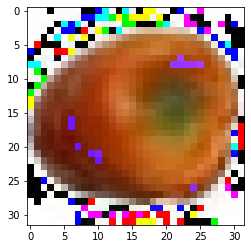

In [ ]:
#############Ottimizzazione sulle immagini con PCA###########################################
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg_pca = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [4,5,6,7,8,9,10],
    "n_neurons": [10,20,40,80,120,160,200,240,280,320,360,400],
#   "learning_rate": [3e-3,3e-4,3e-2]
}


rnd_search_cv_pca = RandomizedSearchCV(keras_reg_pca, param_distribs, n_iter=10, cv=10)

X_train_pca_out_recovered=X_train_pca_out_recovered.astype("uint8").reshape(y_train.shape[0],32,32,3)
X_val_pca_out_recovered=X_val_pca_out_recovered.astype("uint8").reshape(y_val.shape[0],32,32,3)

print(X_train_pca_out_recovered.shape)

plt.imshow(X_train_pca_out_recovered[5,:])
print(y_train[5])
#rnd_search_cv_pca.fit(x_train,y_train,epochs=10,validation_data=(x_val, y_val))
rnd_search_cv_pca.fit(X_train_pca_out_recovered,y_train,epochs=10,validation_data=(X_val_pca_out_recovered, y_val))

print(rnd_search_cv_pca.best_params_)
print(rnd_search_cv_pca.best_score_)

model_pca=rnd_search_cv_pca.best_estimator_.model





In [ ]:
model_pca =  tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),                
        layers.Dense(100, activation="relu", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(100, activation="relu", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(10, activation='softmax',name="layer8"),
    
])

model_pca.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history_pca =model_pca.fit(
  X_train_pca_out_recovered,y_train,
  validation_data=(X_val_pca_out_recovered, y_val),
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)


Epoch 1/10
769/769 [==============================] - 3s 4ms/step - loss: 3.7677 - accuracy: 0.4869 - val_loss: 1.3192 - val_accuracy: 0.7814
Epoch 2/10
769/769 [==============================] - 2s 3ms/step - loss: 1.1574 - accuracy: 0.8001 - val_loss: 0.8279 - val_accuracy: 0.8395
Epoch 3/10
769/769 [==============================] - 2s 3ms/step - loss: 0.7534 - accuracy: 0.8701 - val_loss: 0.7383 - val_accuracy: 0.8426
Epoch 4/10
769/769 [==============================] - 2s 3ms/step - loss: 0.6752 - accuracy: 0.8690 - val_loss: 0.5585 - val_accuracy: 0.8933
Epoch 5/10
769/769 [==============================] - 2s 3ms/step - loss: 0.6069 - accuracy: 0.8807 - val_loss: 0.6341 - val_accuracy: 0.8543
Epoch 6/10
769/769 [==============================] - 2s 3ms/step - loss: 0.5696 - accuracy: 0.8875 - val_loss: 0.8129 - val_accuracy: 0.8102
Epoch 7/10
769/769 [==============================] - 2s 3ms/step - loss: 0.5979 - accuracy: 0.8728 - val_loss: 0.4121 - val_accuracy: 0.9353
Epoch 

In [ ]:
X_new = Apple[0]

NameError: ignored

In [ ]:
print(Apple[1])

/root/.keras/datasets/TRAINING/Apple/APPLE_PINK_LADY_r_105_100.jpg


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
layer1 (Dense)               (None, 280)               860440    
_________________________________________________________________
layer2 (Dense)               (None, 280)               78680     
_________________________________________________________________
layer3 (Dense)               (None, 280)               78680     
_________________________________________________________________
layer4 (Dense)               (None, 280)               78680     
_________________________________________________________________
layer5 (Dense)               (None, 280)               7

In [ ]:
model_pca.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
layer1 (Dense)               (None, 160)               491680    
_________________________________________________________________
layer2 (Dense)               (None, 160)               25760     
_________________________________________________________________
layer3 (Dense)               (None, 160)               25760     
_________________________________________________________________
layer4 (Dense)               (None, 160)               25760     
_________________________________________________________________
layer5 (Dense)               (None, 160)              

Plotting the Traing and Validation accuracy. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

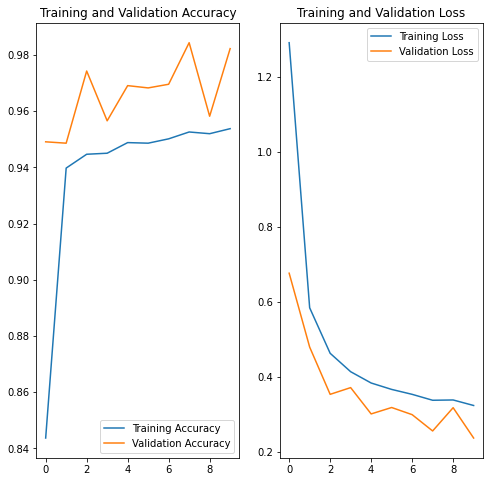

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Plotting the Traing and Validation accuracy for the neural network that use as input the pictures transformed with the PCA. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
acc_pca = history_pca.history['accuracy']
val_acc_pca = history_pca.history['val_accuracy']

loss_pca = history_pca.history['loss']
val_loss_pca = history_pca.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_pca, label='Training Accuracy')
plt.plot(epochs_range, val_acc_pca, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_pca, label='Training Loss')
plt.plot(epochs_range, val_loss_pca, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

Evaluating the final accuracy, through the confusion matrix and other metrics, of the neural network using the test dataset. Solution adapted from [Geron_textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
pred = model.predict(x_test).round(3)
score = tf.nn.softmax(pred)

pred_pca = model_pca.predict(x_test).round(3)
score_pca = tf.nn.softmax(pred_pca)

data_in= np.zeros((10000))
data_out= np.zeros((10000))
data_in_pca= np.zeros((10000))

for i in range(1,10000):
  data_in[i]=np.argmax(score[i])
  data_in_pca[i]=np.argmax(score_pca[i])
  data_out[i]=np.argmax(y_test[i])

#  print(class_names[np.argmax(score[i])],class_names[np.argmax(y_test[i])])
#print(class_names[np.argmax(score)].shape)

#print(class_names[np.argmax(score)],y_test)

[[0.84 0.   0.   0.   0.05 0.05 0.   0.04 0.   0.01]
 [0.   0.93 0.   0.   0.   0.07 0.   0.   0.   0.  ]
 [0.02 0.   0.91 0.   0.   0.   0.01 0.05 0.   0.  ]
 [0.   0.   0.09 0.89 0.   0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.  ]
 [0.08 0.06 0.   0.01 0.   0.8  0.   0.   0.03 0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.06 0.   0.   0.01 0.93 0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.03 0.02 0.67 0.27]
 [0.05 0.   0.02 0.   0.   0.04 0.07 0.   0.02 0.8 ]]
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.87      2161
         1.0       0.78      0.93      0.85       392
         2.0       0.87      0.91      0.89      1049
         3.0       0.95      0.89      0.92      1168
         4.0       0.78      0.98      0.87       434
         5.0       0.85      0.80      0.83      1497
         6.0       0.81      1.00      0.90       641
         7.0       0.69      0.93   

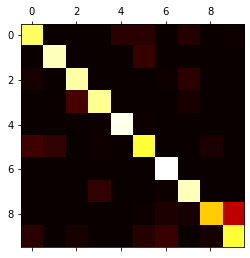

In [ ]:
#print(data_in)
conf_matrix=tf.math.confusion_matrix(data_in,data_out,num_classes=10).numpy()
con_mat_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm)
plt.matshow(con_mat_norm,cmap=plt.cm.hot)
print(metrics.classification_report(data_in,data_out))

In [ ]:
print("Zero-One-Loss: ",zero_one_loss(pred, y_test))

Zero-One-Loss:  0.4193610101396595


[[0.84 0.   0.04 0.   0.03 0.04 0.01 0.   0.03 0.01]
 [0.   0.97 0.   0.   0.   0.03 0.   0.   0.   0.  ]
 [0.07 0.   0.86 0.04 0.02 0.   0.   0.01 0.   0.  ]
 [0.02 0.   0.03 0.94 0.   0.01 0.   0.   0.   0.  ]
 [0.11 0.   0.   0.04 0.85 0.   0.   0.   0.   0.  ]
 [0.07 0.06 0.03 0.01 0.04 0.63 0.   0.   0.1  0.05]
 [0.   0.   0.   0.02 0.   0.   0.88 0.   0.   0.1 ]
 [0.   0.   0.   0.04 0.   0.01 0.15 0.8  0.   0.  ]
 [0.03 0.01 0.   0.   0.15 0.01 0.   0.   0.77 0.04]
 [0.01 0.   0.   0.02 0.   0.07 0.09 0.   0.   0.81]]
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85      2062
         1.0       0.74      0.97      0.84       356
         2.0       0.84      0.86      0.85      1071
         3.0       0.86      0.94      0.90       993
         4.0       0.59      0.85      0.70       379
         5.0       0.83      0.63      0.71      1858
         6.0       0.66      0.88      0.75       593
         7.0       0.98      0.80   

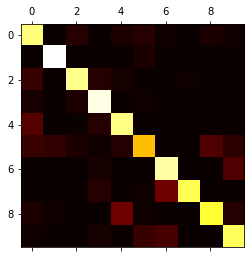

In [ ]:
conf_matrix_pca=tf.math.confusion_matrix(data_in_pca,data_out,num_classes=10).numpy()
con_mat_norm_pca = np.around(conf_matrix_pca.astype('float') / conf_matrix_pca.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm_pca)
plt.matshow(con_mat_norm_pca,cmap=plt.cm.hot)
print(metrics.classification_report(data_in_pca,data_out))

In [ ]:
print("Zero-One-Loss: ",zero_one_loss(pred_pca, y_test))

Zero-One-Loss:  0.20948919074038647


In [9]:
batch_size_cov = 32
img_height_cov = 64
img_width_cov = 64

In [10]:
train_ds_cov = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height_cov, img_width_cov),
  batch_size=batch_size_cov)

Found 30747 files belonging to 10 classes.
Using 24598 files for training.


In [11]:
val_ds_cov = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height_cov, img_width_cov),
  batch_size=batch_size_cov)

Found 30747 files belonging to 10 classes.
Using 6149 files for validation.


In [12]:
test_ds_cov = tf.keras.preprocessing.image_dataset_from_directory(
  data_Y,
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height_cov, img_width_cov),
  batch_size=batch_size_cov)

Found 10454 files belonging to 10 classes.


In [13]:
model_cov = keras.models.Sequential([
      keras.layers.Conv2D(64,7,activation="relu",padding="same",input_shape=[64,64,3]),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(128,3,activation="relu",padding="same"),
      keras.layers.Conv2D(128,3,activation="relu",padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(256,3,activation="relu",padding="same"),
      keras.layers.Conv2D(256,3,activation="relu",padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Flatten(),
      keras.layers.Dense(128,activation="relu"),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64,activation="relu"),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(10,activation="softmax")
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model_cov.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model_cov.fit(
  train_ds_cov,
  validation_data=val_ds_cov,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)


Epoch 1/10
769/769 [==============================] - 61s 37ms/step - loss: 2.8524 - accuracy: 0.2491 - val_loss: 0.6550 - val_accuracy: 0.7852
Epoch 2/10
769/769 [==============================] - 26s 34ms/step - loss: 0.9132 - accuracy: 0.6633 - val_loss: 0.3112 - val_accuracy: 0.8889
Epoch 3/10
769/769 [==============================] - 26s 34ms/step - loss: 0.5760 - accuracy: 0.7890 - val_loss: 0.1240 - val_accuracy: 0.9676
Epoch 4/10
769/769 [==============================] - 26s 34ms/step - loss: 0.4164 - accuracy: 0.8594 - val_loss: 0.0890 - val_accuracy: 0.9709
Epoch 5/10
769/769 [==============================] - 26s 34ms/step - loss: 0.3612 - accuracy: 0.8822 - val_loss: 0.1049 - val_accuracy: 0.9745
Epoch 6/10
769/769 [==============================] - 26s 34ms/step - loss: 0.2487 - accuracy: 0.9175 - val_loss: 0.0885 - val_accuracy: 0.9728
Epoch 7/10
769/769 [==============================] - 26s 34ms/step - loss: 0.2789 - accuracy: 0.9157 - val_loss: 0.0190 - val_accuracy:

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(64, 64, 3)),
        layers.Flatten(),                
        layers.Dense(60, kernel_initializer="he_normal", name="layer1",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(60, kernel_initializer="he_normal", name="layer2",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(60, kernel_initializer="he_normal", name="layer3",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(60, kernel_initializer="he_normal", name="layer4",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.LeakyReLU(alpha=0.2),
        layers.Dense(10, activation='softmax',name="layer8"),
    
])

optimizer = keras.optimizers.Adam(lr=1e-3)

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],optimizer='adam')

history =model.fit(
  train_ds_cov,
  validation_data=val_ds_cov,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)



Epoch 1/10
769/769 [==============================] - 18s 22ms/step - loss: 14.2905 - accuracy: 0.4865 - val_loss: 4.9217 - val_accuracy: 0.7640
Epoch 2/10
769/769 [==============================] - 16s 21ms/step - loss: 4.4526 - accuracy: 0.8304 - val_loss: 3.7252 - val_accuracy: 0.9034
Epoch 3/10
769/769 [==============================] - 16s 21ms/step - loss: 3.7467 - accuracy: 0.8407 - val_loss: 3.1456 - val_accuracy: 0.9001
Epoch 4/10
769/769 [==============================] - 16s 21ms/step - loss: 2.9467 - accuracy: 0.9138 - val_loss: 3.0159 - val_accuracy: 0.7627
Epoch 5/10
769/769 [==============================] - 16s 20ms/step - loss: 2.6937 - accuracy: 0.8495 - val_loss: 2.2009 - val_accuracy: 0.8756
Epoch 6/10
769/769 [==============================] - 16s 21ms/step - loss: 2.1102 - accuracy: 0.8784 - val_loss: 1.6675 - val_accuracy: 0.9390
Epoch 7/10
769/769 [==============================] - 16s 20ms/step - loss: 1.6598 - accuracy: 0.9057 - val_loss: 1.3374 - val_accuracy

In [14]:
res = list(zip(*train_ds_cov.unbatch().as_numpy_iterator()))
x_train_cov = np.array(res[0])

y_train_cov = np.array(res[1])

print(x_train_cov.shape,y_train_cov.shape)

resx = list(zip(*val_ds_cov.unbatch().as_numpy_iterator()))
x_val_cov = np.array(resx[0])

y_val_cov = np.array(resx[1])

print(x_val_cov.shape,y_val_cov.shape)

resz = list(zip(*test_ds_cov.unbatch().as_numpy_iterator()))
x_test_cov = np.array(resz[0])

y_test_cov = np.array(resz[1])

print(x_test_cov.shape,y_test_cov.shape)


(24598, 64, 64, 3) (24598, 10)
(6149, 64, 64, 3) (6149, 10)
(10454, 64, 64, 3) (10454, 10)


In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(64, 64, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(160, kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.L2(0.01)))
        model_prod.add(keras.layers.LeakyReLU(alpha=0.2))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [2,3,4,5],
    "n_neurons": [20,40,60,80],
#   "learning_rate": [3e-3,3e-4,3e-2]
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=30, cv=3,verbose=1)

rnd_search_cv.fit(x_train_cov,y_train_cov,epochs=10,validation_data=(x_val_cov, y_val_cov))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.cv_results_)

model=rnd_search_cv.best_estimator_.model

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 16 is smaller than n_iter=30. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/10
513/513 [==============================] - 3s 5ms/step - loss: 31.8286 - accuracy: 0.4712 - val_loss: 8.1184 - val_accuracy: 0.5905
Epoch 2/10
513/513 [==============================] - 2s 5ms/step - loss: 6.4445 - accuracy: 0.7252 - val_loss: 5.3366 - val_accuracy: 0.7813
Epoch 3/10
513/513 [==============================] - 2s 5ms/step - loss: 4.9711 - accuracy: 0.7955 - val_loss: 3.9274 - val_accuracy: 0.8549
Epoch 4/10
513/513 [==============================] - 2s 4ms/step - loss: 4.0281 - accuracy: 0.8298 - val_loss: 4.5551 - val_accuracy: 0.7644
Epoch 5/10
513/513 [==============================] - 2s 4ms/step - loss: 3.7808 - accuracy: 0.8206 - val_loss: 3.9455 - val_accuracy: 0.7191
Epoch 6/10
513/513 [==============================] - 2s 4ms/step - loss: 3.6229 - accuracy: 0.7809 - val_loss: 2.5813 - val_accuracy: 0.8914
Epoch 7/10
513/513 [==============================] - 2s 5ms/step - loss: 2.8648 - acc

[[0.95 0.   0.   0.   0.   0.03 0.   0.01 0.   0.  ]
 [0.   0.94 0.   0.   0.   0.05 0.   0.   0.   0.01]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.   0.97 0.   0.01 0.   0.   0.   0.  ]
 [0.18 0.   0.   0.   0.81 0.01 0.   0.   0.   0.  ]
 [0.01 0.02 0.01 0.   0.01 0.94 0.   0.   0.01 0.01]
 [0.   0.   0.   0.   0.   0.   0.98 0.   0.   0.02]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.   0.99 0.  ]
 [0.   0.   0.   0.   0.   0.   0.03 0.   0.   0.96]]
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1994
         1.0       0.94      0.94      0.94       463
         2.0       0.99      1.00      1.00      1084
         3.0       1.00      0.97      0.98      1128
         4.0       0.98      0.81      0.89       656
         5.0       0.92      0.94      0.93      1373
         6.0       0.94      0.98      0.96       757
         7.0       0.95      1.00   

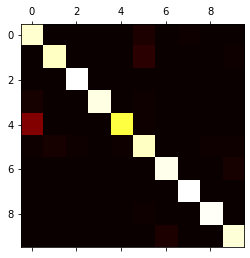

In [16]:
pred = model_cov.predict(x_test_cov).round(3)
score = tf.nn.softmax(pred)

data_in= np.zeros((10000))
data_out= np.zeros((10000))


for i in range(1,10000):
  data_in[i]=np.argmax(score[i])
  data_out[i]=np.argmax(y_test_cov[i])

conf_matrix=tf.math.confusion_matrix(data_in,data_out,num_classes=10).numpy()
con_mat_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm)
plt.matshow(con_mat_norm,cmap=plt.cm.hot)
print(metrics.classification_report(data_in,data_out))

print("Zero-One-Loss: ",zero_one_loss(pred, y_test_cov))


Reduced boltzmann machine. Solution adapted from [Scikit_learn](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

In [ ]:

train_ds_RBM = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  color_mode='grayscale',
  image_size=(32, 32),
  batch_size=batch_size)

res = list(zip(*train_ds_RBM.unbatch().as_numpy_iterator()))
x_train_RBM = np.array(res[0])

y_train_RBM = np.array(res[1])

print(x_train_RBM.shape)






Found 30747 files belonging to 10 classes.
Using 24598 files for training.


KeyboardInterrupt: ignored

In [ ]:

X=x_train_RBM.reshape(x_train_RBM.shape[0],1*32*32)
print(X.shape)


(24598, 1024)


In [ ]:
#print(y_train_RBM)
Y= np.zeros((24598))
for i in range(0,24598):
  Y[i]=np.argmax(y_train_RBM[i])
print(Y[0:10])

[3. 0. 2. 5. 2. 6. 2. 2. 6. 5.]


In [ ]:
def normalize_data(data):  # 0.1<=data[i][j]<=0.9
    data = (data - np.mean(data)) / np.std(data)
    rows,cols = data.shape
    for i in range(rows):
      for j in range(cols):
        if (data[i,j] > 0):
          data[i,j] = 1
        else:
          data[i,j] = 0
    return data

X = normalize_data(X)

In [ ]:
print(X.shape,Y.shape)

(24598, 1024) (24598,)


In [ ]:
rbm = BernoulliRBM(n_components=576, learning_rate=0.06, batch_size=10, n_iter=10, verbose=True, random_state=0)

rbm.fit(X,Y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -309.39, time = 28.69s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -207.16, time = 31.39s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -202.60, time = 31.14s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -185.42, time = 30.93s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -188.48, time = 31.45s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -196.49, time = 30.83s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -186.05, time = 30.75s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -200.02, time = 30.77s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -213.07, time = 30.99s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -180.65, time = 30.61s


BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=576, n_iter=10,
             random_state=0, verbose=True)

In [ ]:
weight = rbm.components_
baise = rbm.intercept_hidden_
baise_vis = rbm.intercept_visible_

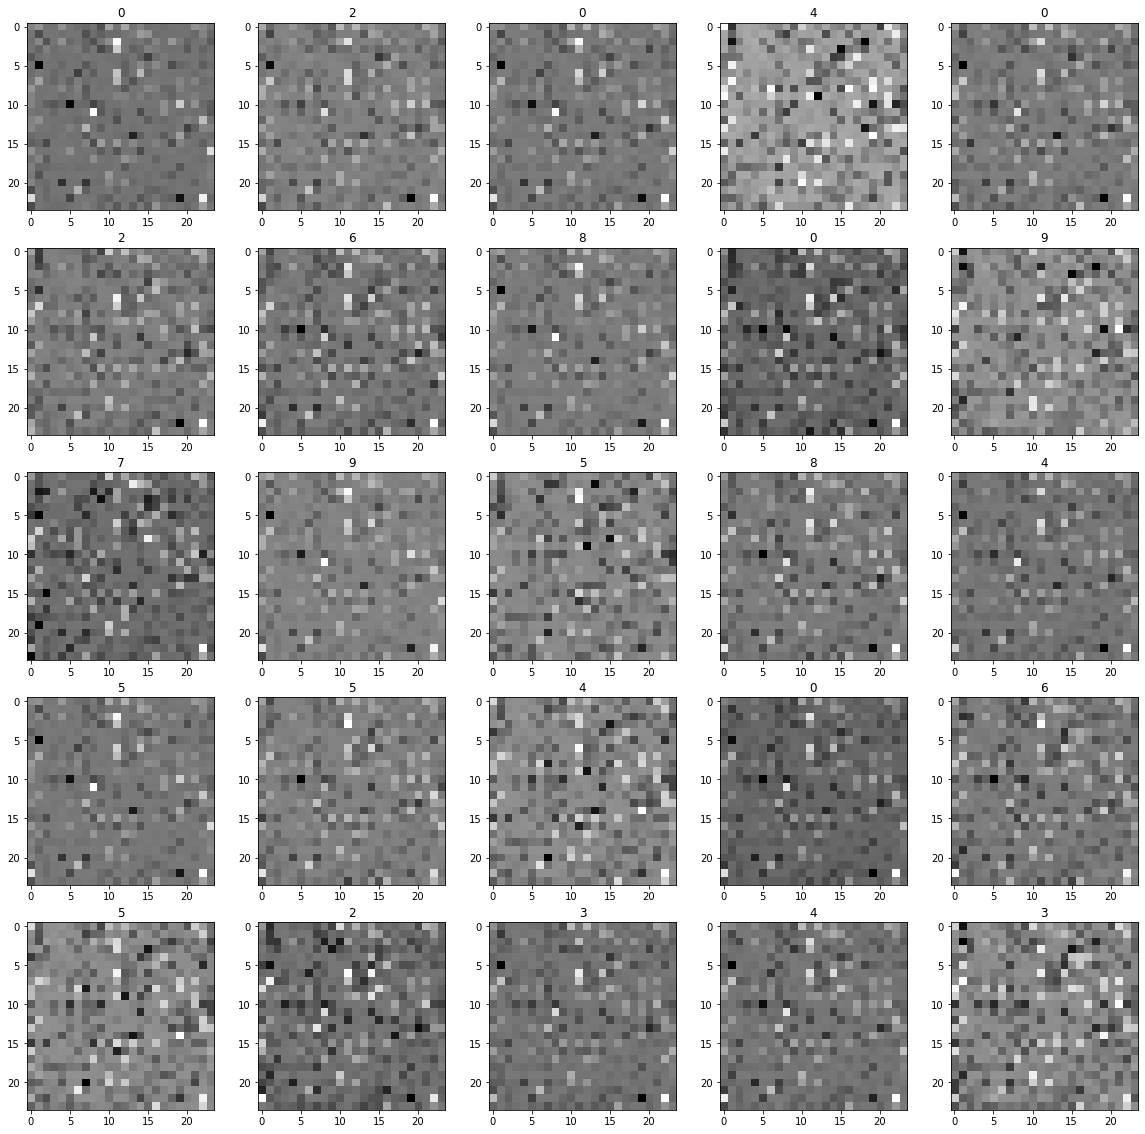

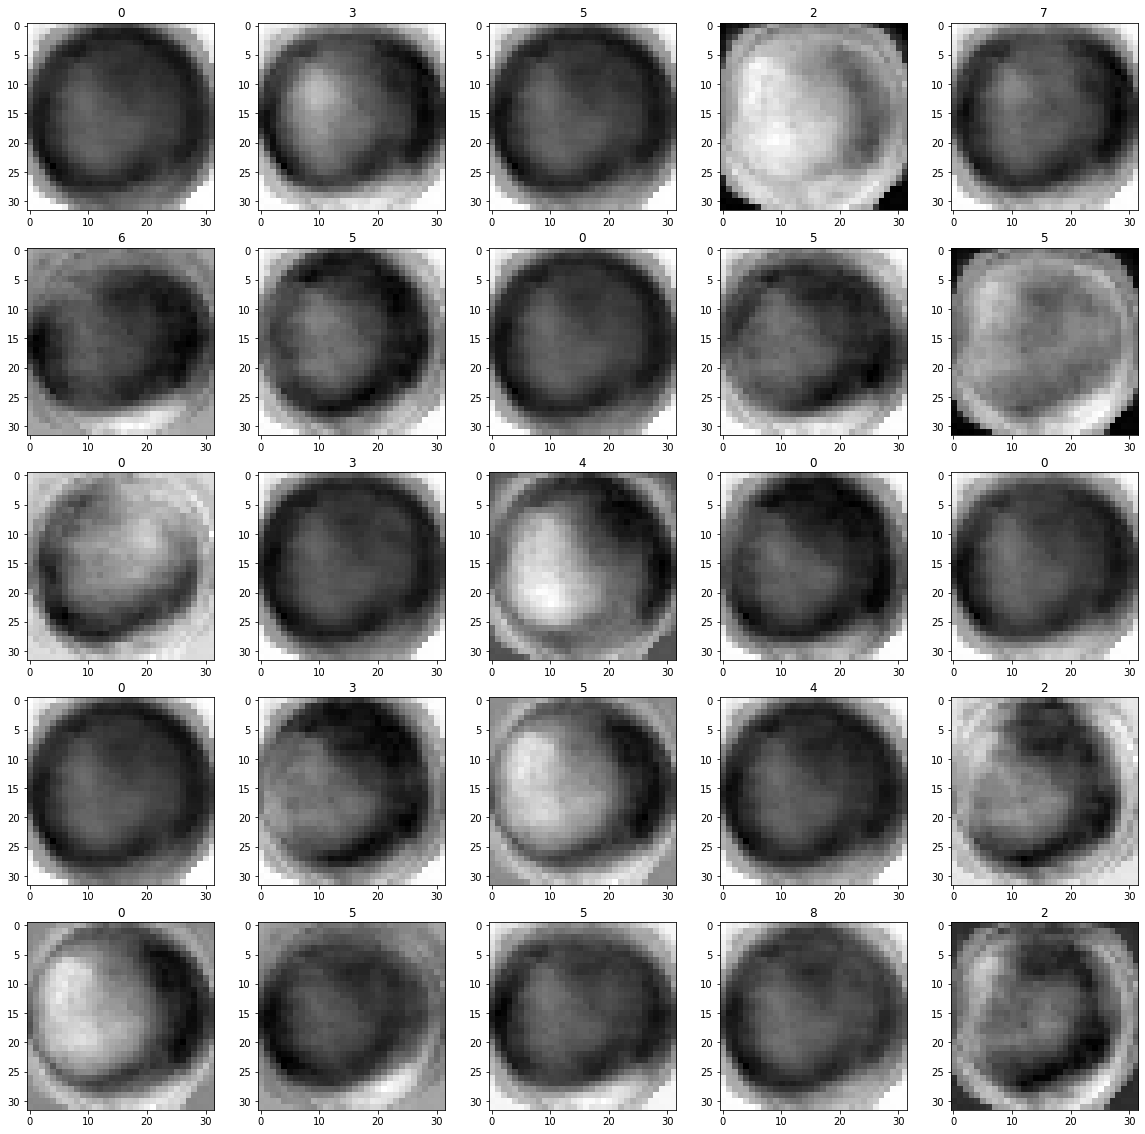

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    hidden_img = np.dot(X[i], weight.T) + baise
    reverimg = np.dot(hidden_img, weight) + baise_vis
    reverimg.shape
    plt.imshow(hidden_img.reshape(24,24), cmap='gray')
    plt.title(np.argmax(labels[i]))

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    hidden_img = np.dot(X[i], weight.T) + baise
    reverimg = np.dot(hidden_img, weight) + baise_vis
    reverimg.shape
    plt.imshow(reverimg.reshape(32,32), cmap='gray')
    plt.title(np.argmax(labels[i]))


In [ ]:
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,verbose=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)],verbose=True)


rbm.learning_rate = 0.03
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 576
logistic.C = 1000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X, Y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -371.61, time = 27.32s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -246.04, time = 29.92s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -180.14, time = 29.95s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -200.27, time = 29.89s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -172.55, time = 29.89s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -221.01, time = 29.84s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -172.97, time = 29.75s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -144.09, time = 30.05s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -159.24, time = 29.88s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -160.29, time = 29.90s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -153.12, time = 30.25s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -152.76, time = 29.80s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -191.70, time = 29.68s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -184.65, time = 29.89s
[

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] .......... (step 2 of 2) Processing logistic, total= 2.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.03,
                              n_components=576, n_iter=20, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=1, verbose=1,
                                    warm_start=False))],
         verbose=True)

In [ ]:


raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 576.
raw_pixel_classifier.fit(X, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min finished


LogisticRegression(C=576.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=1,
                   warm_start=False)

In [ ]:
test_ds_rbm = tf.keras.preprocessing.image_dataset_from_directory(
  data_Y,
  label_mode='categorical',
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)


resx = list(zip(*test_ds_rbm.unbatch().as_numpy_iterator()))
x_test_RBM = np.array(resx[0])

y_test_RBM = np.array(resx[1])


Z=x_test_RBM.reshape(x_test_RBM.shape[0],1*32*32)
Z = normalize_data(Z)

Found 10454 files belonging to 10 classes.


In [ ]:
Z_true= np.zeros((10454))
for i in range(0,10454):
  Z_true[i]=np.argmax(y_test_RBM[i])
print(Z_true[0:10])

[0. 0. 7. 1. 9. 0. 8. 0. 5. 2.]


In [ ]:
Z_predict=rbm_features_classifier.predict(Z)
Z_predict_pixel = raw_pixel_classifier.predict(Z)


[[0.68 0.   0.04 0.01 0.   0.09 0.05 0.03 0.03 0.06]
 [0.02 0.7  0.   0.02 0.06 0.17 0.   0.   0.   0.03]
 [0.07 0.   0.78 0.02 0.01 0.01 0.04 0.01 0.01 0.04]
 [0.07 0.   0.05 0.78 0.   0.01 0.01 0.02 0.01 0.04]
 [0.18 0.02 0.02 0.   0.66 0.06 0.01 0.03 0.02 0.  ]
 [0.11 0.04 0.02 0.01 0.   0.75 0.03 0.   0.03 0.01]
 [0.07 0.   0.07 0.01 0.   0.07 0.65 0.01 0.1  0.03]
 [0.1  0.   0.02 0.03 0.03 0.05 0.01 0.63 0.03 0.09]
 [0.03 0.01 0.01 0.02 0.06 0.04 0.04 0.07 0.41 0.3 ]
 [0.12 0.   0.06 0.04 0.01 0.03 0.04 0.04 0.03 0.63]]
              precision    recall  f1-score   support

         0.0       0.65      0.68      0.66      2039
         1.0       0.86      0.70      0.77       593
         2.0       0.71      0.78      0.74      1046
         3.0       0.86      0.78      0.82      1257
         4.0       0.74      0.66      0.70       644
         5.0       0.66      0.75      0.70      1305
         6.0       0.62      0.65      0.63       782
         7.0       0.58      0.63   

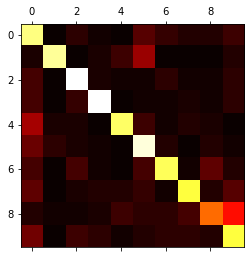

In [ ]:
conf_matrix_L=tf.math.confusion_matrix(Z_predict,Z_true).numpy()
con_mat_norm_L = np.around(conf_matrix_L.astype('float') / conf_matrix_L.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm_L)
plt.matshow(con_mat_norm_L,cmap=plt.cm.hot)
print(metrics.classification_report(Z_predict,Z_true))

[[0.7  0.   0.04 0.01 0.03 0.07 0.04 0.04 0.03 0.04]
 [0.03 0.76 0.   0.01 0.02 0.14 0.02 0.   0.   0.02]
 [0.14 0.   0.65 0.01 0.02 0.04 0.05 0.03 0.01 0.05]
 [0.1  0.01 0.05 0.64 0.02 0.06 0.05 0.02 0.02 0.03]
 [0.19 0.02 0.03 0.   0.52 0.08 0.06 0.05 0.05 0.01]
 [0.09 0.06 0.03 0.04 0.04 0.57 0.03 0.01 0.05 0.07]
 [0.09 0.   0.05 0.01 0.04 0.01 0.67 0.02 0.05 0.06]
 [0.02 0.   0.01 0.05 0.06 0.06 0.03 0.57 0.06 0.15]
 [0.08 0.02 0.01 0.   0.02 0.08 0.02 0.07 0.35 0.34]
 [0.13 0.   0.05 0.04 0.01 0.06 0.05 0.03 0.04 0.6 ]]
              precision    recall  f1-score   support

         0.0       0.58      0.70      0.63      1752
         1.0       0.69      0.76      0.73       437
         2.0       0.73      0.65      0.69      1284
         3.0       0.85      0.64      0.73      1527
         4.0       0.55      0.52      0.54       599
         5.0       0.62      0.57      0.59      1597
         6.0       0.52      0.67      0.58       635
         7.0       0.51      0.57   

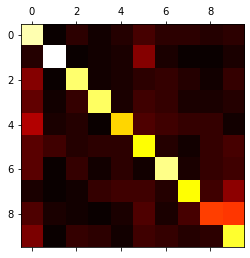

In [ ]:
conf_matrix_L_pixel=tf.math.confusion_matrix(Z_predict_pixel,Z_true).numpy()
con_mat_norm_L_pixel = np.around(conf_matrix_L_pixel.astype('float') / conf_matrix_L_pixel.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm_L_pixel)
plt.matshow(con_mat_norm_L_pixel,cmap=plt.cm.hot)
print(metrics.classification_report(Z_predict_pixel,Z_true))

In [ ]:
def zero_one_loss_rbm(prediction,test):     #predictions, y_test
  y_pred = []
  y_test = []
  loss= []

  for i in range(len(test)):
    y_pred.append(prediction[i])
    y_test.append(np.argmax(test[i]))
  
  for i in range(len(test)):
    if (y_pred[i] != y_test[i]):
      loss.append(1)
    else:
      loss.append(0)
  
  return np.mean(loss)

In [ ]:

print("Zero-One-Loss BRM: ",zero_one_loss_rbm(Z_predict, y_test_RBM))
print("Zero-One-Loss logistic: ",zero_one_loss_rbm(Z_predict_pixel, y_test_RBM))

Zero-One-Loss BRM:  0.32159938779414576
Zero-One-Loss logistic:  0.38884637459345706


Text(0.5, 0.98, '24*24 components extracted by RBM')

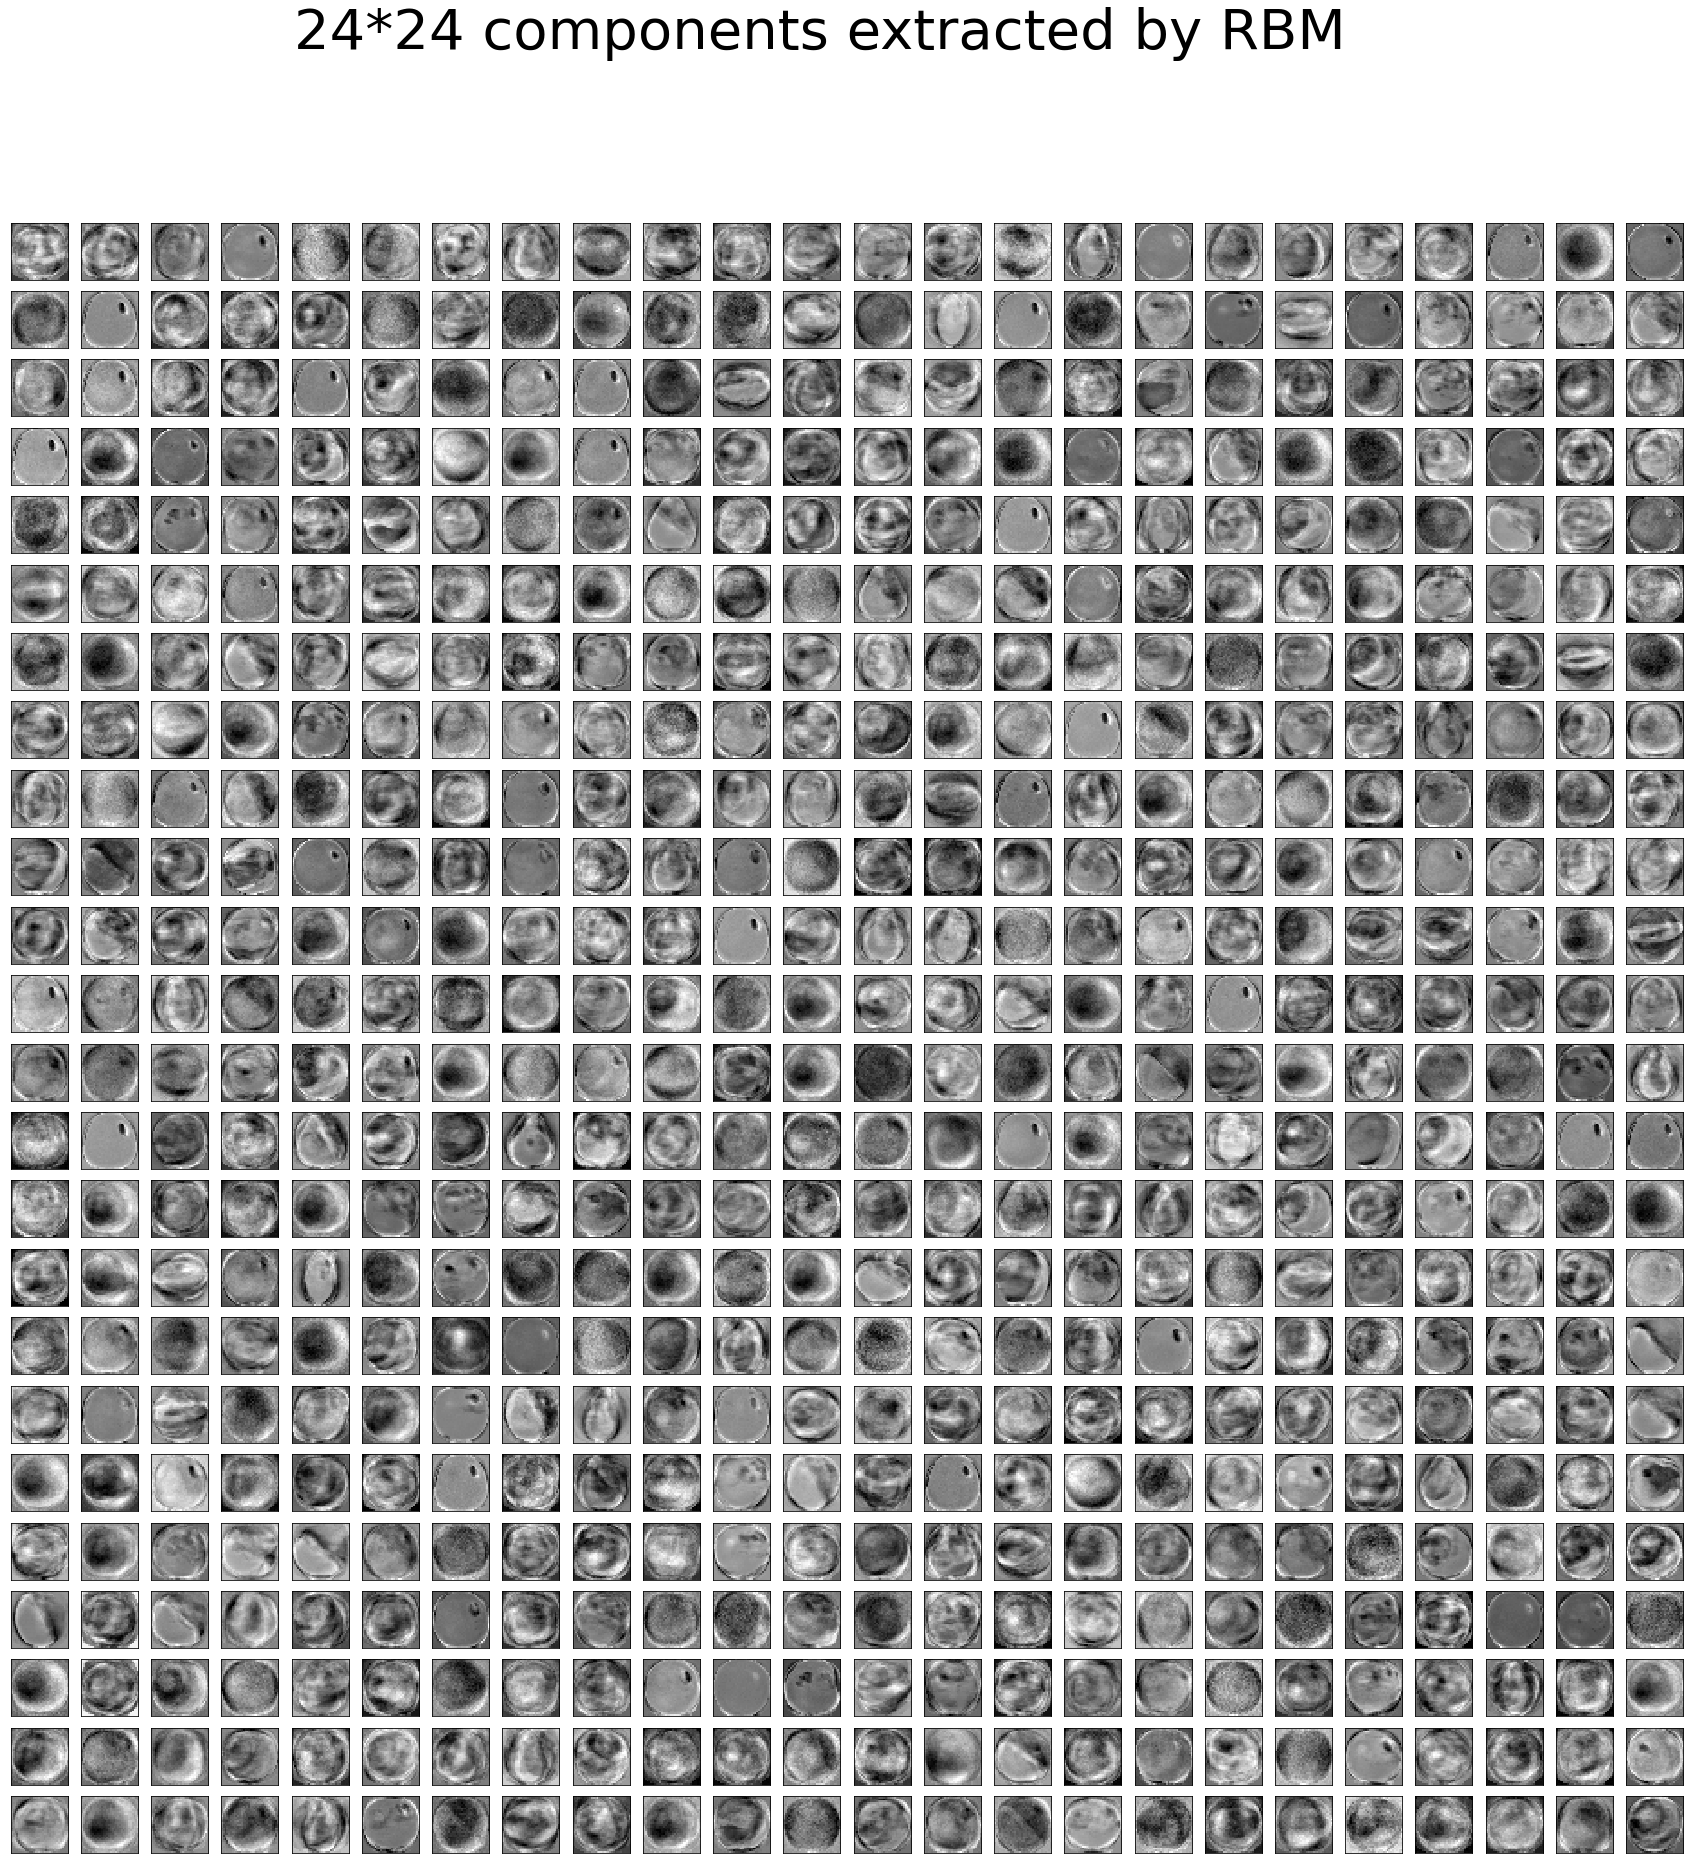

In [ ]:
plt.figure(figsize=(30, 30))
for i, comp in enumerate(rbm.components_):
    plt.subplot(24, 24, i + 1)
    plt.imshow(comp.reshape((32, 32)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('24*24 components extracted by RBM', fontsize=56)
#plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)